0. ARIMA Model performs well when working with a time series where the data is directly related to the time stamp.
1. ARIMA Model is base on Stationary Assumption: no clear trend, looks almost horizontal with constant variance.
2. ACF: Correlation between D and D-1 (Today and yesterday), PACF: Residual from the data point to the line
3. Identification of an AR model is often best done with the PACF (A sharp drop after lag 'k' suggests an AR-k model should be used), Identification of an MA model is often best done with the ACF (a gradual decline suggests an MA model).
4. Components: AR+I+MA (p,d,q)  
   - AR(Auto-Regressive): Predict movement
   - I(Integrated): Making non-stationary data to stationary.
   - MA(Moving Average): Smoothing
5. Repeat differencing until it's stationary.
6. If seasonal, use 12 instead of 1

In [98]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima    # for determining ARIMA orders, if pmdarima is not installed, do: pip install pmdarima
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8) # Adjusts the configuration of the plots we will create

In [70]:
# If your date column is daily data instead of month, you need to do the following:
# df.index.freq = 'D'
df = pd.read_csv(r"C:\Users\Cody\Desktop\airline_passengers.csv",index_col='Month',parse_dates=True)
df=df.dropna()
df.index.freq = 'MS' # Why this?

In [71]:
df.shape

(144, 1)

In [26]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [15]:
df.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [10]:
# Drop duplicates if needed
# df = df.drop_duplicates()

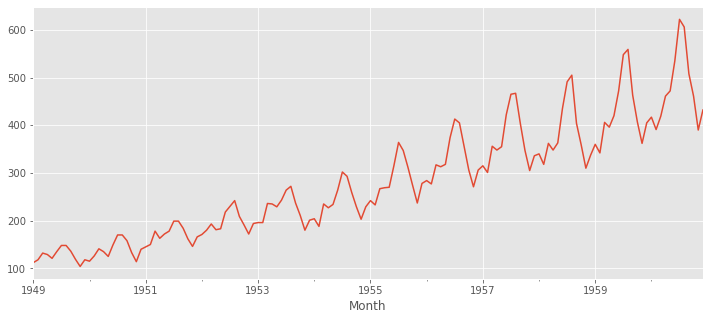

In [69]:
df['Thousands of Passengers'].plot(figsize=(12,5))
plt.show()

In [72]:
# Function to test for stationarity.
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [73]:
adf_test(df['Thousands of Passengers'].dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [61]:
# Non-stationary, so do differencing. If stationary, just skip it and do auto_arima
# My data looks seasonal, so shift(12). If non-seasonal, shift(1)
df['Thousands of Passengers First Differencing'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(12)

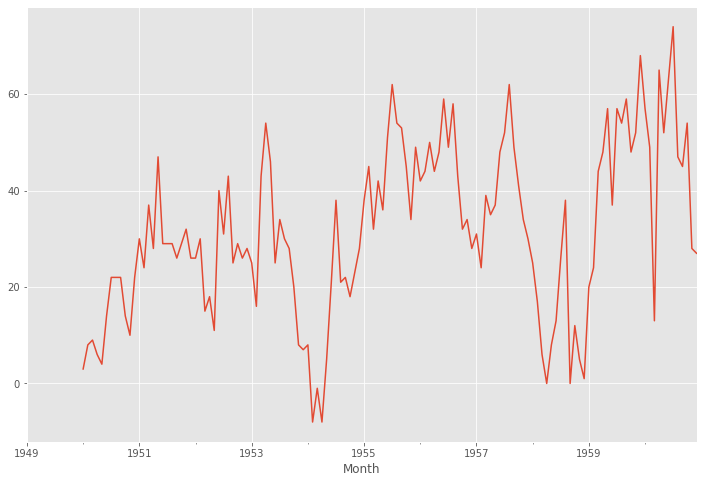

In [62]:
df['Thousands of Passengers First Differencing'].plot()
plt.show()

In [66]:
# Check to see if differencing makes it stationary, it not, differencing again.
adf_test(df['Thousands of Passengers First Differencing'].dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.383021
p-value                   0.011551
# lags used               1.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [93]:
# Auto-fit the ARIMA MODEL
## If not seasonal, just set seasonal=False and m=1?
auto_arima(df['Thousands of Passengers'],seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Sun, 30 Jul 2023   AIC                           1017.847
Time:                                     21:55:42   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.601      0.000      -1.057      -0.907
sigma2       129.3114     14.556      8.884      0.000     100.782     157.841
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
# Split the data into train/test sets
## can I use this as a universal train and test size?
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [102]:
# Fit the model
model = SARIMAX(train['Thousands of Passengers'],order=(2,1,1),seasonal_order=(1,1,[],12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                -447.010
Date:                             Sun, 30 Jul 2023   AIC                            904.019
Time:                                     22:07:39   BIC                            917.915
Sample:                                 01-01-1949   HQIC                           909.662
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4998      1.054     -0.474      0.635      -2.565       1.565
ar.L2          0.0126      0.293      0.043      0.966      -0.561       0.586
ma.L1          0.2888      1.066      0.271      0.786      -1.800       2.378
ar.S.L12      -0.0943      0.086     -1.096      0.273      -0.263       0.074
sigma2       107.0648     13.506      7.927      0.000      80.593     133.537
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.97   Prob(JB):                         0.42
Heteroskedasticity (H):               1.61   Skew:                            -0.12
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Obtain predicted values
start = len(train)
end = len(train) + len(test) - 1

In [105]:
Predictions = results.predict(start,end,typ='levels').rename('Test Predictions')

[]

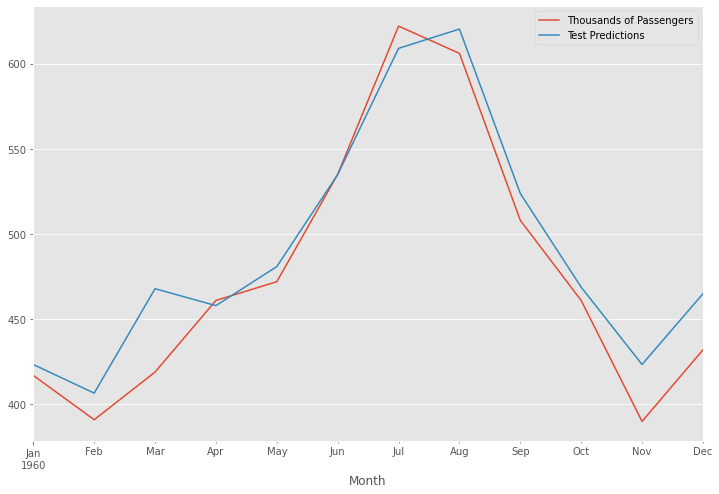

In [131]:
# Plot predictions against known values
test['Thousands of Passengers'].plot(figsize=(12,8),legend=True)
Predictions.plot(legend=True)
plt.plot()

In [114]:
# Evaluate the Model using MSE and RMSE, the smaller the better/more accurate
rmse(test['Thousands of Passengers'],Predictions)

21.69398119122195

In [115]:
mean_squared_error(test['Thousands of Passengers'],Predictions)

470.6288199250918

In [121]:
# Retrain the model on the full data and forecast one year into the future
#(df)+11 means 1 month + 12 months, so 1 year
model = SARIMAX(train['Thousands of Passengers'],order=(2,1,1),seasonal_order=(1,1,[],12))
results = model.fit()
fcast = results.predict(start=len(df),end=len(df)+11,typ='levels').rename('Forecast')

[]

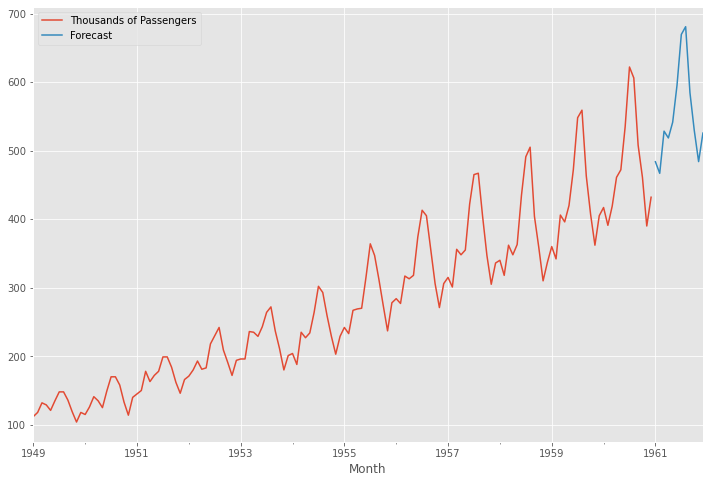

In [128]:
# Plot the forecasted values alongside the original data
df['Thousands of Passengers'].plot(figsize=(12,8),legend=True)
fcast.plot(legend=True)
plt.plot()